# Slide: Multi-Date Crowns Overview
**We Have**  
- Sequence of orthomosaics (same area, different dates)  
- Per-date crown polygons from Detectree2  

**Goal**  
Identify which polygons across dates represent the same physical trees to measure real phenological change.

**Why It's Difficult**  
- Geolocation drift  
- Detection variation (lighting, shadows, season, wind)  
- Polygon inconsistency (splits, merges, misses)  
- Real biological change (growth, pruning, leaf/flower phases)  

Below: All 5 orthomosaics with detected crowns (yellow outline).

Crown dir: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/input/input_crowns
Ortho dir: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/input/input_om
Found 5 crown files; 5 ortho files.
Selected OM ids: [1, 2, 3, 4, 5]
Saved figure to: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/output/all_oms_crowns_overview.png
Summary: [{'om_id': 1, 'crowns': 80, 'has_ortho': True}, {'om_id': 2, 'crowns': 116, 'has_ortho': True}, {'om_id': 3, 'crowns': 130, 'has_ortho': True}, {'om_id': 4, 'crowns': 150, 'has_ortho': True}, {'om_id': 5, 'crowns': 150, 'has_ortho': True}]
Saved figure to: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/output/all_oms_crowns_overview.png
Summary: [{'om_id': 1, 'crowns': 80, 'has_ortho': True}, {'om_id': 2, 'crowns': 116, 'has_ortho': True}, {'om_id': 3, 'crowns': 130, 'has_ortho': True}, {'om_id': 4, 'crowns': 150, 'has_ortho': True}, {'om_id': 5, 'crowns': 150, 'has_ortho': True}]


Crown dir: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/input/input_crowns
Ortho dir: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/input/input_om
Found 5 crown files; 5 ortho files.
Selected OM ids: [1, 2, 3, 4, 5]
Saved figure to: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/output/all_oms_crowns_overview.png
Summary: [{'om_id': 1, 'crowns': 80, 'has_ortho': True}, {'om_id': 2, 'crowns': 116, 'has_ortho': True}, {'om_id': 3, 'crowns': 130, 'has_ortho': True}, {'om_id': 4, 'crowns': 150, 'has_ortho': True}, {'om_id': 5, 'crowns': 150, 'has_ortho': True}]
Saved figure to: /Users/hbot07/VS Code/Drone-Phenology-Monitoring/output/all_oms_crowns_overview.png
Summary: [{'om_id': 1, 'crowns': 80, 'has_ortho': True}, {'om_id': 2, 'crowns': 116, 'has_ortho': True}, {'om_id': 3, 'crowns': 130, 'has_ortho': True}, {'om_id': 4, 'crowns': 150, 'has_ortho': True}, {'om_id': 5, 'crowns': 150, 'has_ortho': True}]


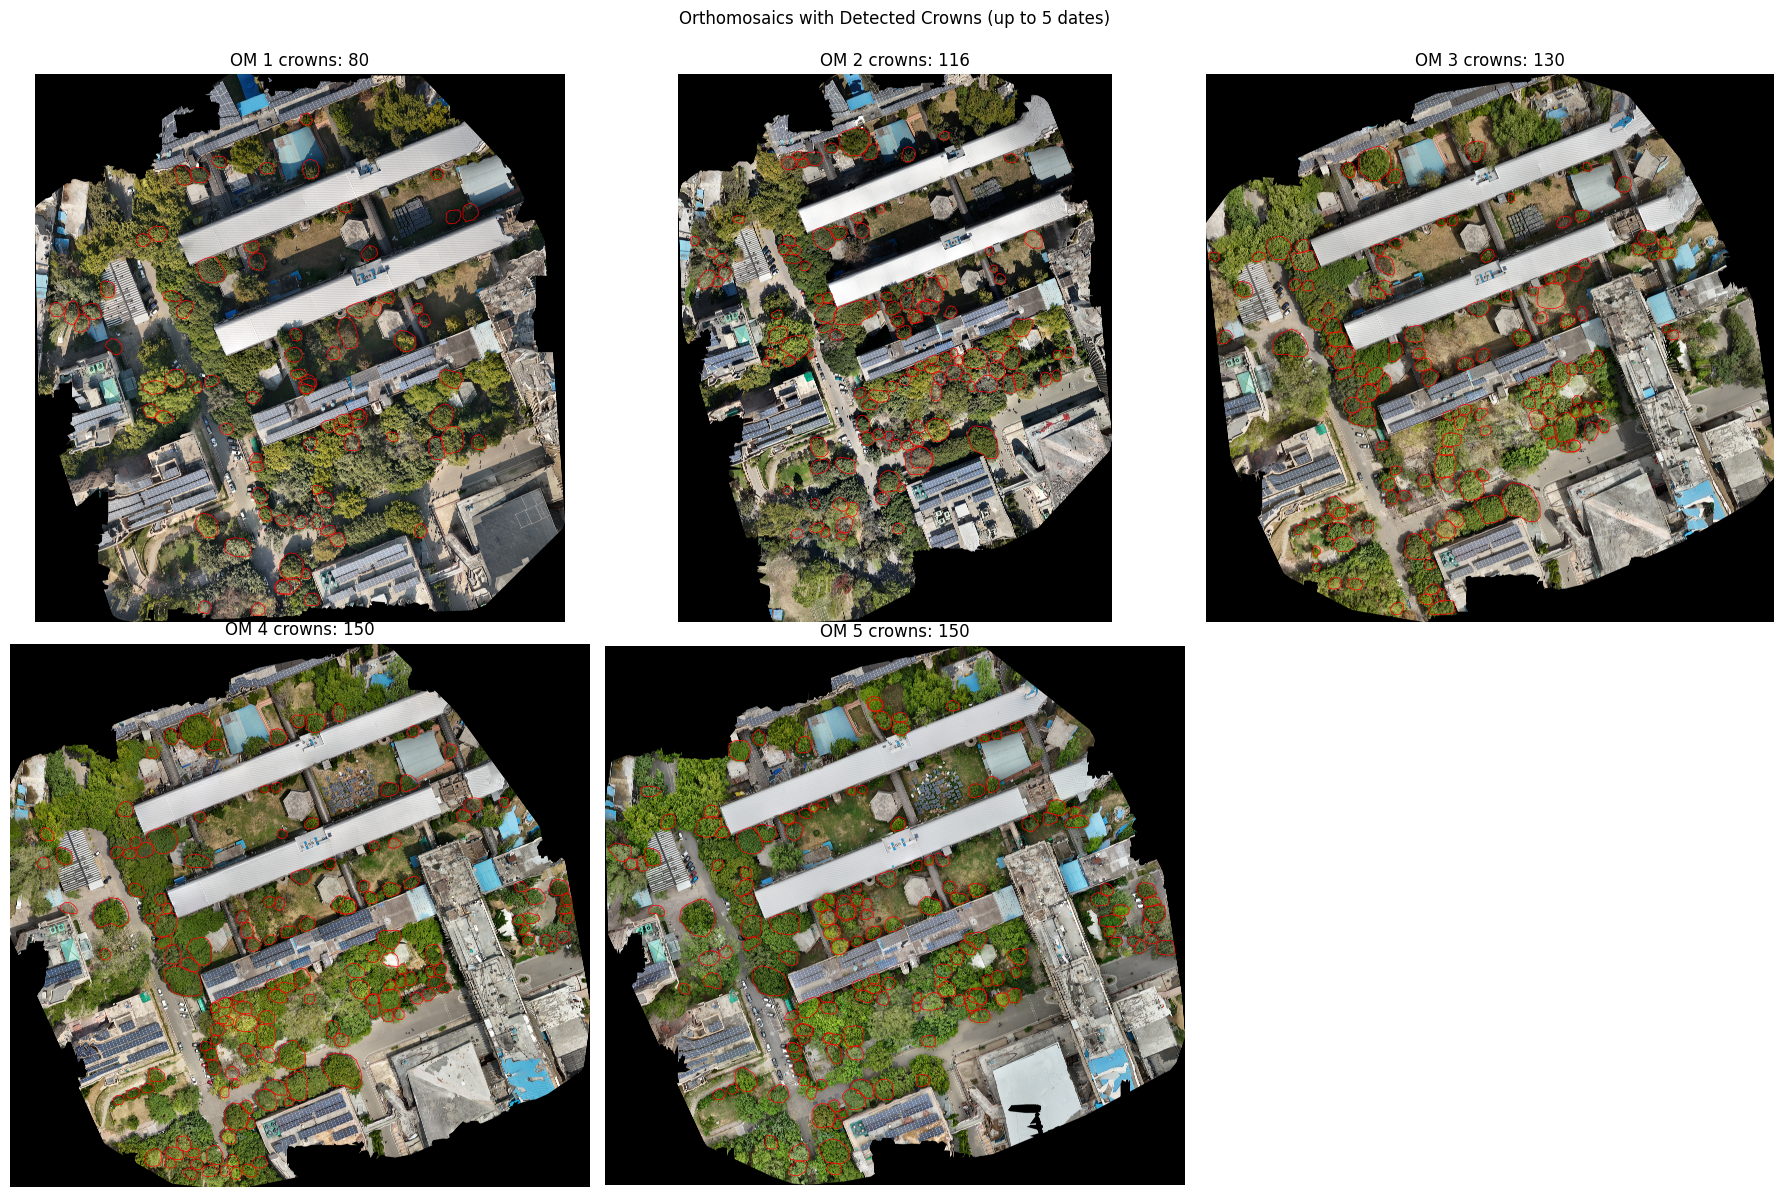

In [3]:
# Generate a multi-panel figure of up to 5 orthomosaics with detected crown polygons
import os, re, math, json
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Resolve input directories relative to this notebook
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
crown_dir = os.path.join(repo_root, 'input', 'input_crowns')
ortho_dir = os.path.join(repo_root, 'input', 'input_om')
print('Crown dir:', crown_dir)
print('Ortho dir:', ortho_dir)

if not os.path.isdir(crown_dir):
    raise FileNotFoundError(f'Missing crown directory: {crown_dir}')

crown_files = [os.path.join(crown_dir, f) for f in os.listdir(crown_dir) if f.lower().endswith('.gpkg')]
ortho_files = [os.path.join(ortho_dir, f) for f in os.listdir(ortho_dir) if f.lower().endswith('.tif')] if os.path.isdir(ortho_dir) else []
if not crown_files:
    raise RuntimeError('No crown .gpkg files found.')
print(f'Found {len(crown_files)} crown files; {len(ortho_files)} ortho files.')

def extract_id(path):
    m = re.search(r'(\d+)', os.path.basename(path))
    return int(m.group(1)) if m else None

crowns_by_id = {}
for cf in crown_files:
    cid = extract_id(cf)
    crowns_by_id[cid if cid is not None else cf] = cf
orthos_by_id = {}
for of in ortho_files:
    oid = extract_id(of)
    orthos_by_id[oid if oid is not None else of] = of

# Select up to 5 ids that have BOTH crowns and orthos; fallback to crowns only if needed
numeric_common = sorted([i for i in crowns_by_id.keys() if isinstance(i, int) and i in orthos_by_id])
if not numeric_common:
    # Fallback: use crown ids (numeric or not) sorted by string
    ordered_keys = [k for k in crowns_by_id.keys() if isinstance(k, int)]
    ordered_keys = sorted(ordered_keys) if ordered_keys else sorted(crowns_by_id.keys(), key=lambda x: str(x))
    selected_ids = ordered_keys[:5]
else:
    selected_ids = numeric_common[:5]

print('Selected OM ids:', selected_ids)

n = len(selected_ids)
cols = min(3, max(1, n))
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1 or cols == 1:
    axes = np.array(axes).reshape(rows, cols)

summary = []
for idx, oid in enumerate(selected_ids):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    crown_path = crowns_by_id[oid]
    ortho_path = orthos_by_id.get(oid)

    try:
        gdf = gpd.read_file(crown_path)
    except Exception as e:
        ax.set_title(f'OM {oid}: read error')
        ax.text(0.5, 0.5, str(e), ha='center')
        ax.axis('off')
        continue

    img = None
    extent = None
    if ortho_path and os.path.exists(ortho_path):
        try:
            with rasterio.open(ortho_path) as src:
                try:
                    img = src.read([1, 2, 3])
                    img = np.moveaxis(img, 0, -1)
                    if img.dtype != np.uint8:
                        img = ((img - img.min()) / (img.ptp() + 1e-9) * 255).astype(np.uint8)
                except Exception:
                    pass
                extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
                # Reproject crowns to raster CRS if needed
                try:
                    if gdf.crs and src.crs and gdf.crs != src.crs:
                        gdf = gdf.to_crs(src.crs)
                except Exception:
                    pass
        except Exception as e:
            print(f'Warning: could not open ortho {ortho_path}: {e}')

    if img is not None:
        ax.imshow(img, extent=extent, origin='upper')
    try:
        gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)
    except Exception:
        pass

    ax.set_title(f'OM {oid} crowns: {len(gdf)}')
    ax.axis('off')
    summary.append({'om_id': oid, 'crowns': len(gdf), 'has_ortho': bool(img is not None)})

# Hide unused axes
for j in range(n, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

plt.suptitle('Orthomosaics with Detected Crowns (up to 5 dates)', y=0.995)
plt.tight_layout()

# Save figure
out_dir = os.path.join(repo_root, 'output')
os.makedirs(out_dir, exist_ok=True)
fig_path = os.path.join(out_dir, 'all_oms_crowns_overview.png')
plt.savefig(fig_path, dpi=220)
print('Saved figure to:', fig_path)
print('Summary:', summary)
